# Crochet & Knitting Search Engine — Advanced Demo Notebook

This notebook demonstrates **advanced** Elasticsearch querying and visualization for my mini-course-project.

It covers:
- Connecting to Elasticsearch and checking the index
- Facet aggregations with bar charts
- A reusable **search()** function supporting: query, filters, only-PDF toggle, sorting, pagination
- **PDF-first ranking** vs **relevance** comparison
- Filtered searches by **fiber art**, **yarn weight**, **stitches**, **techniques**

> Requirements: `elasticsearch`, `pandas`, and `matplotlib` installed in the current environment.


## 0. (Optional) Install dependencies
If needed, run:


In [1]:
pip install elasticsearch pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional, Dict, Any

ES_URL = 'http://localhost:9200'
INDEX = 'patterns_v2'

es = Elasticsearch(ES_URL)
es.info()

ObjectApiResponse({'name': 'BGD474JRL3', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'AvngZ38-TFuuwy18z0WYXw', 'version': {'number': '9.2.4', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': 'dfc5c38614c29a598e132c035b66160d3d350894', 'build_date': '2026-01-08T22:07:25.170027027Z', 'build_snapshot': False, 'lucene_version': '10.3.2', 'minimum_wire_compatibility_version': '8.19.0', 'minimum_index_compatibility_version': '8.0.0'}, 'tagline': 'You Know, for Search'})

In [3]:
# List indices and check document count in the working index
indices = es.cat.indices(format='json')
count = es.count(index=INDEX)
pd.DataFrame(indices), count

(   health status        index                    uuid pri rep docs.count  \
 0  yellow   open  patterns_v2  cQDfzan-QY2kgUpAlGmskg   1   1       9110   
 1  yellow   open     patterns  u5ASwbe-Qa6-0RhJ1FNcZw   1   1       4000   
 
   docs.deleted store.size pri.store.size dataset.size  
 0            0      5.5mb          5.5mb        5.5mb  
 1            0      3.2mb          3.2mb        3.2mb  ,
 ObjectApiResponse({'count': 4000, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}))

## 1. Facet aggregations (distributions) + charts
We compute terms aggregations for **fiber_art**, **yarn_weight**, **stitches_used**, and **techniques_used**.

In [4]:
agg_body = {
  'size': 0,
  'aggs': {
    'by_fiber_art':   { 'terms': { 'field': 'fiber_art',   'size': 10 } },
    'by_yarn_weight': { 'terms': { 'field': 'yarn_weight', 'size': 20 } },
    'by_stitch':      { 'terms': { 'field': 'stitches_used',   'size': 50 } },
    'by_technique':   { 'terms': { 'field': 'techniques_used', 'size': 50 } }
  }
}
aggs = es.search(index=INDEX, body=agg_body)['aggregations']
aggs.keys()

dict_keys(['by_fiber_art', 'by_yarn_weight', 'by_stitch', 'by_technique'])

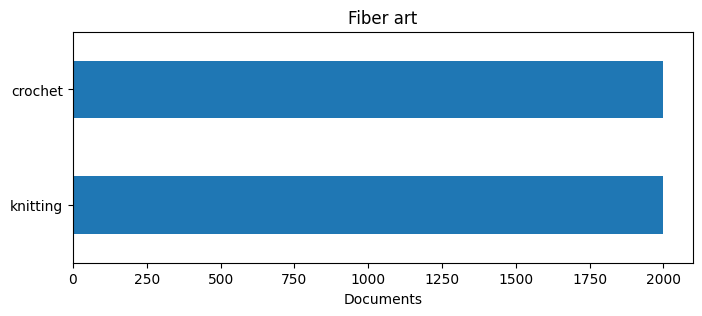

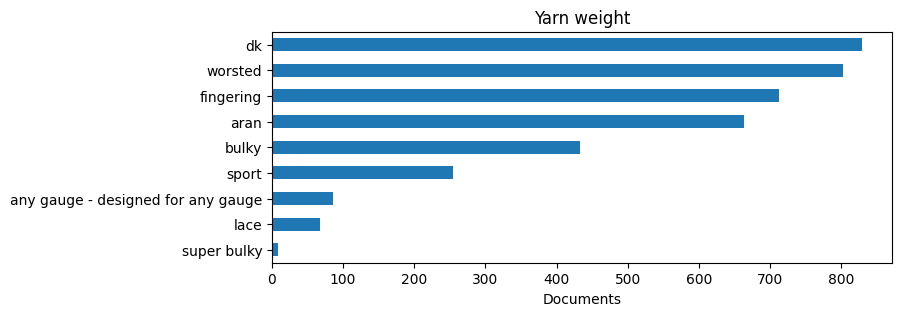

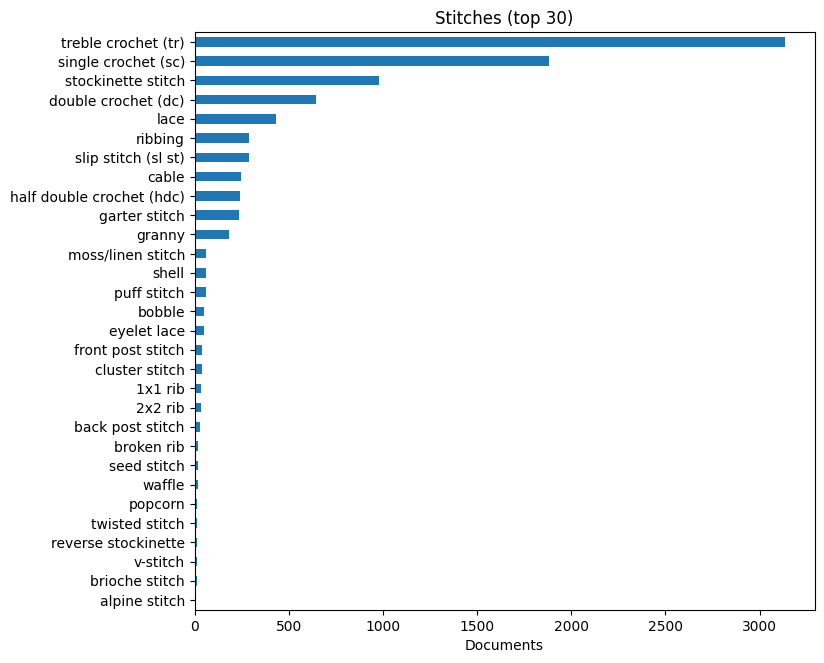

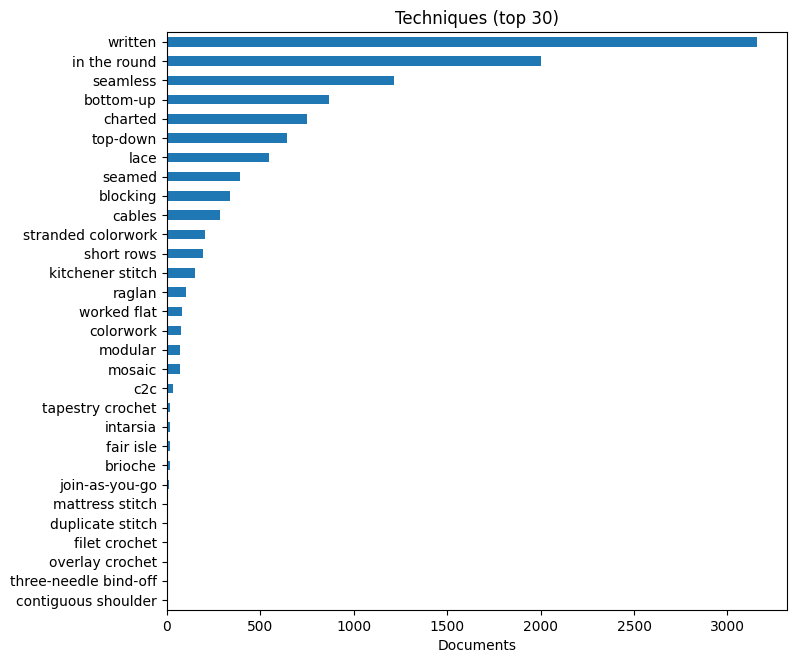

(        key  doc_count
 0   crochet       2000
 1  knitting       2000,
          key  doc_count
 0         dk        830
 1    worsted        803
 2  fingering        713
 3       aran        664
 4      bulky        433)

In [5]:
def buckets_to_df(agg: Dict[str, Any], title: str, top_n: Optional[int]=None):
    buckets = agg.get('buckets', [])
    df = pd.DataFrame(buckets)
    if not df.empty:
        df = df[['key','doc_count']]
        if top_n:
            df = df.head(top_n)
        ax = df.plot(kind='barh', x='key', y='doc_count', legend=False, figsize=(8, max(3, len(df)*0.25)))
        ax.set_title(title)
        ax.set_xlabel('Documents')
        ax.set_ylabel('')
        plt.gca().invert_yaxis()
        plt.show()
    return df

df_fiber = buckets_to_df(aggs['by_fiber_art'], 'Fiber art')
df_weight = buckets_to_df(aggs['by_yarn_weight'], 'Yarn weight', top_n=15)
df_stitch = buckets_to_df(aggs['by_stitch'], 'Stitches (top 30)', top_n=30)
df_tech   = buckets_to_df(aggs['by_technique'], 'Techniques (top 30)', top_n=30)
df_fiber.head(), df_weight.head()

## 2. Reusable search() helper
Supports: free-text, filters, only-PDF, sorting, pagination; returns results and fresh facets for the current filter context.

In [6]:
from typing import Tuple

def _build_sort(sort: str):
    if sort == 'rating':
        return [{ 'rating_average': 'desc' }]
    if sort == 'favorites':
        return [{ 'favorites_count': 'desc' }]
    if sort == 'pdfFirst':
        return [{ 'has_pdf': 'desc' }, { 'rating_average': 'desc' }]
    if sort == 'nameAsc':
        return [{ 'name.raw': 'asc' }]
    if sort == 'nameDesc':
        return [{ 'name.raw': 'desc' }]
    return ['_score']  # relevance

def _term_filters(field: str, values: Optional[List[str]]):
    if not values:
        return []
    return [{ 'terms': { field: values } }]

def search(q: str='', fiber_art: Optional[List[str]]=None, yarn_weight: Optional[List[str]]=None,
           stitches: Optional[List[str]]=None, techniques: Optional[List[str]]=None, only_pdf: bool=False,
           sort: str='relevance', page: int=1, size: int=20) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    must = []
    if q and q.strip():
        must.append({
            'multi_match': {
                'query': q,
                'fields': ['name^6','stitches_used','techniques_used','sizes_available','fiber_art','yarn_weight']
            }
        })
    else:
        must.append({ 'match_all': {} })

    filters = []
    filters += _term_filters('fiber_art', fiber_art)
    filters += _term_filters('yarn_weight', yarn_weight)
    filters += _term_filters('stitches_used', stitches)
    filters += _term_filters('techniques_used', techniques)
    if only_pdf:
        filters.append({ 'term': { 'has_pdf': True } })

    body = {
        '_source': ['id','name','designer_name','fiber_art','yarn_weight','best_link','has_pdf','rating_average','favorites_count'],
        'from': (page-1)*size,
        'size': size,
        'sort': _build_sort(sort),
        'query': { 'bool': { 'must': must, 'filter': filters } },
        'aggs': {
            'by_fiber_art':   { 'terms': { 'field': 'fiber_art',   'size': 10 } },
            'by_yarn_weight': { 'terms': { 'field': 'yarn_weight', 'size': 20 } },
            'by_stitch':      { 'terms': { 'field': 'stitches_used',   'size': 50 } },
            'by_technique':   { 'terms': { 'field': 'techniques_used', 'size': 50 } }
        }
    }
    resp = es.search(index=INDEX, body=body)
    hits = resp['hits']['hits']
    rows = [h['_source'] for h in hits]

    df = pd.DataFrame(rows)
    if not df.empty:
        df['link_type'] = df['has_pdf'].map(lambda x: 'PDF' if x else 'External/Ravelry')
    return df, resp.get('aggregations', {})


## 3. PDF-first ranking vs relevance (comparison)
We compare the top results under **relevance** vs **PDF-first** sorting for the same query.

In [9]:
query_text = 'hat'  # change to anything: 'hat', 'blanket', 'shawl', etc.
df_rel, _ = search(q=query_text, sort='relevance', page=1, size=10)
df_pdf, _ = search(q=query_text, sort='pdfFirst', page=1, size=10)

print('Top 10 — Relevance: PDFs in top 10 =', int(df_rel['has_pdf'].sum()) if not df_rel.empty else 0)
display(df_rel[['name','fiber_art','yarn_weight','has_pdf','best_link', 'id']])

print('Top 10 — PDF-first: PDFs in top 10 =', int(df_pdf['has_pdf'].sum()) if not df_pdf.empty else 0)
display(df_pdf[['name','fiber_art','yarn_weight','has_pdf','best_link', 'id']])


Top 10 — Relevance: PDFs in top 10 = 8


,name,fiber_art,yarn_weight,has_pdf,best_link,id
0,Hat,Knitting,Bulky,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1176966
1,Hat Shaped Hat,Knitting,Bulky,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,167528
2,0815 Hat,Knitting,Aran,False,http://www.ravelry.com/dls/69359/574589,986297
3,1898 Hat,Knitting,Worsted,False,https://seamenschurch.org/wp-content/uploads/2...,410814
4,3D Hat,Knitting,Sport,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7394298
5,Ali Hat,Knitting,Worsted,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,788500
6,Alpine Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1072494
7,Angel Hat,Knitting,Aran,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,731071
8,Ardleigh Hat,Knitting,Bulky,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1230721
9,Arrows Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7428244


Top 10 — PDF-first: PDFs in top 10 = 10


,name,fiber_art,yarn_weight,has_pdf,best_link,id
0,2026 Winter Games Hat,Knitting,Worsted,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7492042
1,Arrows Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7428244
2,B186 Galway Diamond Hat,Knitting,Worsted,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7464686
3,Basket-Wave Hat,Knitting,Worsted,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7482993
4,Brain Eater Fish Hat,Crochet,Aran,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1344796
5,Calgary - hat,Knitting,Worsted,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1165967
6,Daisy Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7452526
7,FRENCH KiSS hat,Knitting,Sport,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7487109
8,Fright & Delight Hat,Knitting,Worsted,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7365491
9,Sassy Cat Hat,Crochet,Aran,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7412984


## 4. Filtered search examples
Demonstrate practical filters using normalized `keyword` fields.
- Knitting + DK
- Stitches: stockinette stitch (if present)
- Techniques: seamless (if present)

> Tip: You can first inspect the facet buckets below and pick values that exist in your dataset.

In [10]:
_, current_aggs = search(q='', page=1, size=0)
current_aggs['by_fiber_art']['buckets'][:5], current_aggs['by_yarn_weight']['buckets'][:5]

([{'key': 'crochet', 'doc_count': 2000},
  {'key': 'knitting', 'doc_count': 2000}],
 [{'key': 'dk', 'doc_count': 830},
  {'key': 'worsted', 'doc_count': 803},
  {'key': 'fingering', 'doc_count': 713},
  {'key': 'aran', 'doc_count': 664},
  {'key': 'bulky', 'doc_count': 433}])

In [11]:
df_knit_dk, _ = search(q='', fiber_art=['knitting'], yarn_weight=['dk'], sort='pdfFirst', page=1, size=10)
display(df_knit_dk[['name','fiber_art','yarn_weight','has_pdf','best_link', 'id']])


,name,fiber_art,yarn_weight,has_pdf,best_link,id
0,An Italian Autumn Cowl,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7283011
1,Arrows Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7428244
2,Daisy Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7452526
3,Enchanted Evening Cap,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7302216
4,Light As A Feather Cowl,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7440142
5,Mitsu8 Socks,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7420568
6,Skyscraper Windows Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7488755
7,Sleepy Owls Baby Blanket,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1362113
8,Smallidays,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7483299
9,Toad Elf Hat,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7478286


In [12]:
df_filtered, _ = search(q='', fiber_art=['knitting'], yarn_weight=['dk'],
                         stitches=['stockinette stitch'], techniques=['seamless'],
                         sort='relevance', page=1, size=10)
display(df_filtered[['name','fiber_art','yarn_weight','has_pdf','best_link', 'id']])


,name,fiber_art,yarn_weight,has_pdf,best_link,id
0,0-1601 New Traditions,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1164...,7296573
1,0-966 Sweet Pumpkin,Knitting,DK,False,http://www.garnstudio.com/pattern.php?id=6365&...,440446
2,220-26 Fern Feast,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1023...,1134501
3,222-32 Swing by Spring Top,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1023...,1134509
4,234-28 Cinnamon Beanie,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1097...,1266441
5,240-7 Dazzling Diamonds Vest,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1131...,1322067
6,242-22 a Cardinal Song Hat,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1163...,7289546
7,242-22 b Cardinal Song Neck-Warmer,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1163...,7289548
8,242-48 Silver Day Hat,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1159...,7284050
9,246-32 Leknes Hat,Knitting,DK,False,https://www.garnstudio.com/pattern.php?id=1167...,7312306


## 5. Only-PDF search
Limit results to documents where we have a local PDF (`has_pdf=true`).

In [13]:
df_pdf_only, _ = search(q='blanket', only_pdf=True, sort='relevance', page=1, size=10)
display(df_pdf_only[['name','fiber_art','yarn_weight','has_pdf','best_link', 'id']])


,name,fiber_art,yarn_weight,has_pdf,best_link,id
0,Blanket of Calm,Crochet,None,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1016541
1,F.E.F.E. Blanket,Crochet,Aran,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7474505
2,Memory Blanket,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,517197
3,Pig in blanket,Knitting,None,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,7486486
4,The Boulevard Blanket,Knitting,Bulky,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,581681
5,Lovey Blanket Bear Security Blanket Teddy,Crochet,Aran,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,815843
6,Beautiful Shells Blanket,Crochet,Any gauge - designed for any gauge,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,567901
7,Granny Stripe Blanket,Crochet,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,1255598
8,Magic Number Blanket,Knitting,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,917966
9,Spoke Flower Blanket,Crochet,DK,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...,909915


## 6. Pagination demo
Retrieve page 2 for a query with sorting.

In [14]:
df_page1, _ = search(q='hat', sort='favorites', page=1, size=5)
df_page2, _ = search(q='hat', sort='favorites', page=2, size=5)
print('Page 1:')
display(df_page1[['name','favorites_count','has_pdf','best_link', 'id']])
print('Page 2:')
display(df_page2[['name','favorites_count','has_pdf','best_link', 'id']])


Page 1:


,name,favorites_count,has_pdf,best_link
0,Classic Ribbed Hat,75089,False,https://www.purlsoho.com/create/2023/09/24/cla...
1,Sockhead Slouch Hat,71605,False,http://bohoknits.blogspot.com/2009/05/sockhead...
2,Garter Ear Flap Hat,62030,False,https://www.purlsoho.com/create/2022/12/05/gar...
3,Jason's Cashmere Hat,60355,False,https://www.shop.sweetfiberyarns.com/blogs/in-...
4,Berry Baby Hat,57420,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...


Page 2:


,name,favorites_count,has_pdf,best_link
0,Classic Cuffed Hat,47861,False,https://www.purlsoho.com/create/2024/12/14/cla...
1,Rikke Hat,44124,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...
2,Hurricane Hat,39445,False,http://lovehestia.wordpress.com/2012/07/19/hur...
3,February Hat,37241,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...
4,Divine Hat,34226,True,C:\Users\PSLAVCHE\Documents\University\AI\Croc...
